# Text and Sentiment Analysis

### Loading packages

In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
import os
import plotly.express as px
import plotly.graph_objs as go
import collections
from collections import defaultdict

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from nltk.util import ngrams
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Dataset

In [183]:
# load dataset
df = pd.read_csv("C:\\Users\\wgero\\Downloads\\chatgpt_reviews.csv")
df.dropna(inplace=True)

In [184]:
df.head()

Unnamed: 0                             review_id       pseudo_author_id  \
0           0  1558c5f6-90b3-468c-856b-428e353758a4  490575543899954542249   
2           2  e69568f3-b2ec-4f89-afc1-6d09646a8f21  227174291354574282039   
3           3  9c08eb11-cfb6-4023-bb2a-7fdceef094fb  118101522543376663422   
4           4  fdaa9cb9-9261-44ff-badb-1ccb45c91d32  285365291129892694152   
5           5  a1ccbbed-6041-49a8-8bb0-61ff32b2fa4f  753870300138344476874   

                        author_name  \
0  Pa****************************S)   
2                   So***********oy   
3                   Mo***********il   
4                       lo*******ay   
5                      Aj********ap   

                                         review_text  review_rating  \
0                                 What type this app              4   
2                                  Bahut Achcha work              5   
3                                     Pretty good UI              4   
4                                              First              5   
5  Love u OpenAI, Open AI Team, Sam Altman and El...              5   

   review_likes author_app_version     review_timestamp  
0             3           1.0.0016  2023-07-25 15:01:35  
2             2           1.0.0016  2023-07-25 15:02:58  
3             0           1.0.0016  2023-07-25 15:03:03  
4             0           1.0.0016  2023-07-25 15:03:58  
5             0           1.0.0016  2023-07-25 15:04:19

## Top 10 App Versions out of 26

In [185]:
import seaborn as sns

# Define the ChatGPT color gradient
chatgpt_colors = ["#3ACB7D", "#1CA391", "#008CA7", "#006E82", "#005266"]

# Group by author_app_version and count review ratings
top_app_versions = df.groupby('author_app_version')['review_rating'].count().sort_values(ascending=False).head(10).index.tolist()

# Group by author_app_version and count review ratings, then reset index
app_versions_df = df.groupby(['author_app_version'])['review_rating'].count().reset_index()

# Filter the DataFrame to include only the top app versions
app_versions_df = app_versions_df[app_versions_df['author_app_version'].isin(top_app_versions)]

# Plotting
plt.figure(figsize=(20,8))
sns.barplot(data=app_versions_df, x='author_app_version', y='review_rating', palette=chatgpt_colors)
plt.xlabel('Author App Version')
plt.ylabel('Review Ratings Count')
plt.title('Top 10 Author App Versions by Review Ratings Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [186]:
# dataset that has only the top ten versions
# Group by author_app_version and count review ratings
top_app_versions = df.groupby('author_app_version')['review_rating'].count().sort_values(ascending=False).head(10).index.tolist()

# Filter the DataFrame to include only the top app versions
df_filtered = df[df['author_app_version'].isin(top_app_versions)]

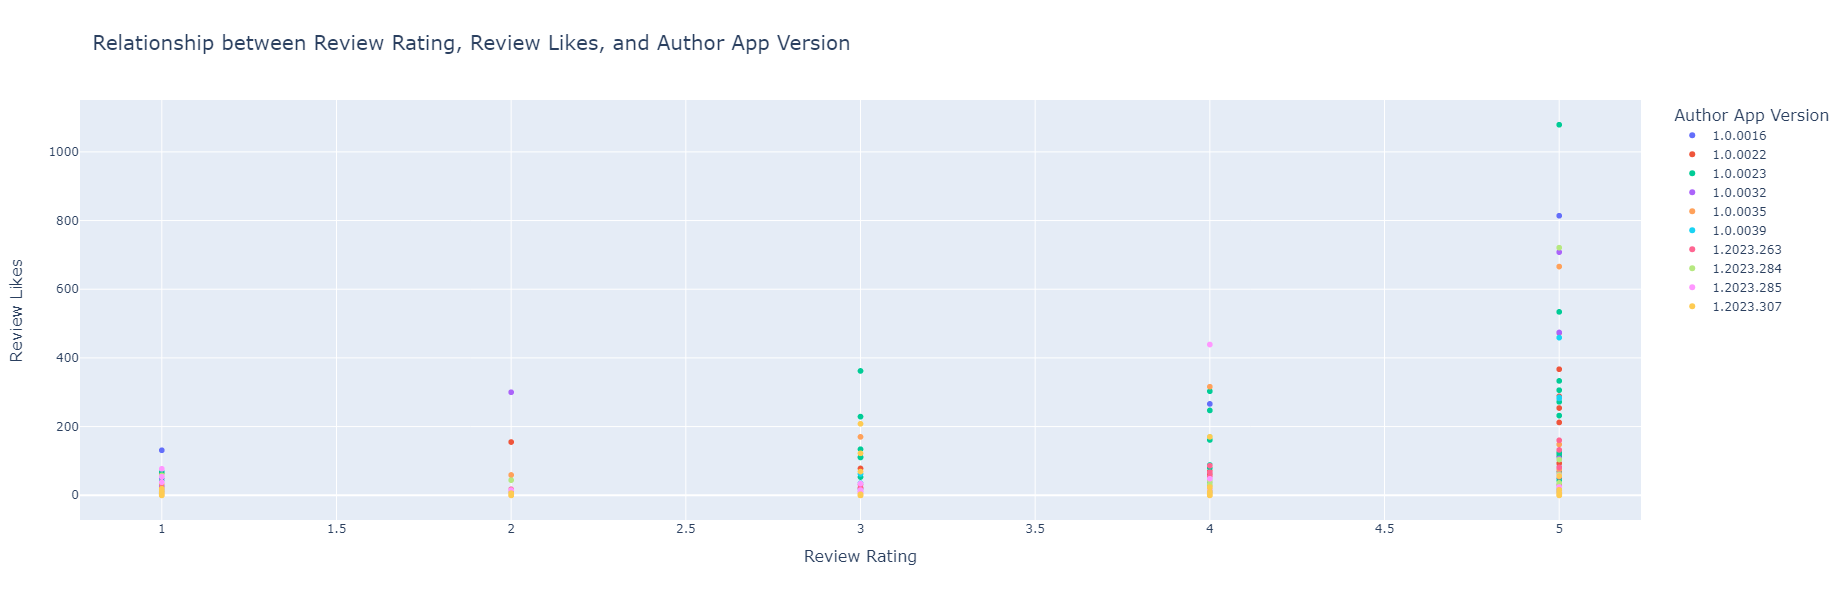

In [187]:
# Relationship between review rating and likes, and app version scatter plot 
fig = px.scatter(df_filtered, x='review_rating', y='review_likes', color='author_app_version', 
                 title='Relationship between Review Rating, Review Likes, and Author App Version',
                 labels={'review_rating': 'Review Rating', 'review_likes': 'Review Likes'},
                 hover_data={'author_app_version': True})

# Customize layout
fig.update_layout(
    title=dict(font=dict(size=20)),
    xaxis=dict(title=dict(font=dict(size=16))),
    yaxis=dict(title=dict(font=dict(size=16))),
    legend=dict(title='Author App Version', title_font=dict(size=16)),
    hoverlabel=dict(font_size=12),
    hovermode='closest',
    width=900,
    height=600
)

fig.show()

# Sentiment Analysis
How do people feel about the ChatGPT App?

In [188]:
# funtion to clean text!
def clean(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub(r'#','',text)
    text = re.sub(r'RT[\s]+','',text)
    text = re.sub(r'[^\w]', ' ', text)
    return text

In [189]:
# Create function to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

In [190]:
# Assuming df is your DataFrame containing the data
# Select relevant columns and drop rows with missing values
reviews_data = df[['review_text', 'author_app_version', 'review_rating', 'review_likes']].dropna()

# Reset index
reviews_data.reset_index(drop=True, inplace=True)

# Clean review text
reviews_data['CleanReview'] = reviews_data['review_text'].apply(clean)

# Perform sentiment analysis
reviews_data['subjectivity'] = reviews_data['CleanReview'].apply(getSubjectivity)
reviews_data['polarity'] = reviews_data['CleanReview'].apply(getPolarity)
reviews_data['analysis'] = reviews_data['polarity'].apply(getAnalysis)

reviews_data.head(12)

review_text author_app_version  \
0                                  What type this app           1.0.0016   
1                                   Bahut Achcha work           1.0.0016   
2                                      Pretty good UI           1.0.0016   
3                                               First           1.0.0016   
4   Love u OpenAI, Open AI Team, Sam Altman and El...           1.0.0016   
5   ChatGPT is incredibly limited, but good enough...           1.0.0016   
6   I've been using the ChatGPT Android app for a ...           1.0.0016   
7                                   New way of search           1.0.0016   
8                                           Brilliant           1.0.0016   
9   Awesome & Minimal UI No Bugs And Glitches I sa...           1.0.0016   
10                   Thanks for the android version✨️           1.0.0016   
11  This Artificial Intelligence is very good. I d...           1.0.0016   

    review_rating  review_likes  \
0               4             3   
1               5             2   
2               4             0   
3               5             0   
4               5             0   
5               5             0   
6               4             5   
7               5             0   
8               5             0   
9               5             2   
10              5             0   
11              4             4   

                                          CleanReview  subjectivity  polarity  \
0                                  what type this app      0.000000  0.000000   
1                                   bahut achcha work      0.000000  0.000000   
2                                      pretty good ui      0.800000  0.475000   
3                                               first      0.333333  0.250000   
4   love u openai  open ai team  sam altman and el...      0.550000  0.250000   
5   chatgpt is incredibly limited  but good enough...      0.473214  0.244643   
6   i ve been using the chatgpt android app for a ...      0.812500  0.687500   
7                                   new way of search      0.454545  0.136364   
8                                           brilliant      1.000000  0.900000   
9   awesome   minimal ui no bugs and glitches i sa...      0.680000  0.468333   
10                   thanks for the android version        0.200000  0.200000   
11  this artificial intelligence is very good  i d...      0.851964 -0.216607   

    analysis  
0    neutral  
1    neutral  
2   positive  
3   positive  
4   positive  
5   positive  
6   positive  
7   positive  
8   positive  
9   positive  
10  positive  
11  negative

In [167]:
# new df2 that includes the top ten versions
reviews_data.to_csv('reviews_data.csv', index=False)

df2 = pd.read_csv('reviews_data.csv')
df2

df2.head(12)

review_text author_app_version  \
0                                  What type this app           1.0.0016   
1                                   Bahut Achcha work           1.0.0016   
2                                      Pretty good UI           1.0.0016   
3                                               First           1.0.0016   
4   Love u OpenAI, Open AI Team, Sam Altman and El...           1.0.0016   
5   ChatGPT is incredibly limited, but good enough...           1.0.0016   
6   I've been using the ChatGPT Android app for a ...           1.0.0016   
7                                   New way of search           1.0.0016   
8                                           Brilliant           1.0.0016   
9   Awesome & Minimal UI No Bugs And Glitches I sa...           1.0.0016   
10                   Thanks for the android version✨️           1.0.0016   
11  This Artificial Intelligence is very good. I d...           1.0.0016   

    review_rating  review_likes  \
0               4             3   
1               5             2   
2               4             0   
3               5             0   
4               5             0   
5               5             0   
6               4             5   
7               5             0   
8               5             0   
9               5             2   
10              5             0   
11              4             4   

                                          CleanReview  subjectivity  polarity  \
0                                  what type this app      0.000000  0.000000   
1                                   bahut achcha work      0.000000  0.000000   
2                                      pretty good ui      0.800000  0.475000   
3                                               first      0.333333  0.250000   
4   love u openai  open ai team  sam altman and el...      0.550000  0.250000   
5   chatgpt is incredibly limited  but good enough...      0.473214  0.244643   
6   i ve been using the chatgpt android app for a ...      0.812500  0.687500   
7                                   new way of search      0.454545  0.136364   
8                                           brilliant      1.000000  0.900000   
9   awesome   minimal ui no bugs and glitches i sa...      0.680000  0.468333   
10                   thanks for the android version        0.200000  0.200000   
11  this artificial intelligence is very good  i d...      0.851964 -0.216607   

    analysis  
0    neutral  
1    neutral  
2   positive  
3   positive  
4   positive  
5   positive  
6   positive  
7   positive  
8   positive  
9   positive  
10  positive  
11  negative

In [194]:
# filterDa taFrame to include only top 10 versions
top_versions = df2['author_app_version'].value_counts().head(10).index
df_top_versions = df2[df2['author_app_version'].isin(top_versions)]
df2

review_text author_app_version  \
0                                     What type this app           1.0.0016   
1                                      Bahut Achcha work           1.0.0016   
2                                         Pretty good UI           1.0.0016   
3                                                  First           1.0.0016   
4      Love u OpenAI, Open AI Team, Sam Altman and El...           1.0.0016   
...                                                  ...                ...   
32838                                       Very helpful         1.2023.307   
32839  the new feature where you can talk is great, b...         1.2023.312   
32840                                 Sure Super Soundly         1.2023.307   
32841                                          great app           1.0.0039   
32842                          good app I really like it         1.2023.263   

       review_rating  review_likes  \
0                  4             3   
1                  5             2   
2                  4             0   
3                  5             0   
4                  5             0   
...              ...           ...   
32838              5             0   
32839              5             0   
32840              5             0   
32841              5             0   
32842              5             0   

                                             CleanReview  subjectivity  \
0                                     what type this app      0.000000   
1                                      bahut achcha work      0.000000   
2                                         pretty good ui      0.800000   
3                                                  first      0.333333   
4      love u openai  open ai team  sam altman and el...      0.550000   
...                                                  ...           ...   
32838                                       very helpful      0.300000   
32839  the new feature where you can talk is great  b...      0.568182   
32840                                 sure super soundly      0.651852   
32841                                          great app      0.750000   
32842                          good app i really like it      0.400000   

       polarity  analysis  
0      0.000000   neutral  
1      0.000000   neutral  
2      0.475000  positive  
3      0.250000  positive  
4      0.250000  positive  
...         ...       ...  
32838  0.200000  positive  
32839  0.478788  positive  
32840  0.411111  positive  
32841  0.800000  positive  
32842  0.450000  positive  

[32843 rows x 8 columns]

In [195]:
# group by author_app_version and calculate overall subjectivity, polarity, and sentiment score
version_sentiment_stats = df_top_versions.groupby('author_app_version').agg(
    overall_subjectivity=('subjectivity', 'mean'),
    overall_polarity=('polarity', 'mean'),
    overall_sentiment_score=('analysis', lambda x: (x == 'positive').mean() - (x == 'negative').mean())
)

# Display the overall sentiment statistics for each version
print(version_sentiment_stats)

                    overall_subjectivity  overall_polarity  \
author_app_version                                           
1.0.0016                        0.517756          0.377744   
1.0.0022                        0.515740          0.380026   
1.0.0023                        0.503395          0.326997   
1.0.0032                        0.521779          0.436093   
1.0.0035                        0.528368          0.407797   
1.0.0039                        0.522459          0.415540   
1.2023.263                      0.519782          0.437311   
1.2023.284                      0.502057          0.421776   
1.2023.285                      0.511777          0.422305   
1.2023.307                      0.501748          0.413610   

                    overall_sentiment_score  
author_app_version                           
1.0.0016                           0.693548  
1.0.0022                           0.685959  
1.0.0023                           0.621320  
1.0.0032                 

# Word Cloud

In [148]:
# Filter reviews from the top 10 versions
top_versions_reviews = df2[df2['author_app_version'].isin(top_app_versions)]['review_text']

# Concatenate all reviews into a single string
all_reviews = ' '.join(top_versions_reviews)

# Generate word cloud
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=None, 
                      min_font_size=10).generate(all_reviews)

# Plot word cloud
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()

In [176]:
# Filter negative reviews
negative_reviews = df2[df2['analysis'] == 'negative']['review_text']

# Concatenate all negative reviews into a single string
all_negative_reviews = ' '.join(negative_reviews)

# Generate word cloud for negative sentiments
negative_wordcloud = WordCloud(width=800, height=800,
                               background_color='white',
                               stopwords=STOPWORDS,
                               min_font_size=10).generate(all_negative_reviews)

# Plot the word cloud for negative sentiments
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(negative_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()


# Time Series Forecasting

In [224]:
# copying 'review_timestamp' column from df to df2
df2['review_timestamp'] = df['review_timestamp']

# drop rows with missing values in 'review_timestamp'
df2.dropna(subset=['review_timestamp'], inplace=True)

# get day from timestamp
def get_day(review_timestamp):
    day = review_timestamp.split(' ')[0]
    return day

# filter DataFrame to include only the top 10 versions
top_10_versions = df2['author_app_version'].value_counts().head(10).index.tolist()
df2_filtered = df2[df2['author_app_version'].isin(top_10_versions)].copy()  # Use .copy() to ensure modifying a new DataFrame

# apply get_day function to review_timestamp column
df2_filtered['day'] = df2_filtered['review_timestamp'].apply(get_day)

# group by day, sentiment analysis, and app version
time_sentiment_df = df2_filtered.groupby(['day', 'analysis']).size().reset_index(name='counts')

# Plotting
fig = px.line(time_sentiment_df, 
              x='day', 
              y='counts',  
              color='analysis', 
              color_discrete_sequence=['#336699', '#993333', '#4040ff', '#ff4040', '#6699ff', '#ff9966'],
              title='Sentiment Analysis Over Time for Top 10 App Versions',
              labels={'day': 'Day', 'counts': 'Number of Sentiments'})

fig.show()